# Лабораторная работа № 7

In [1]:
!pip install matplotlib_inline

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!wget https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz

--2022-12-14 05:18:51--  https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 170498071 (163M) [application/x-gzip]
Saving to: ‘cifar-10-python.tar.gz’

cifar-10-python.tar 100%[===================>] 162.60M  13.2MB/s    in 15s     

2022-12-14 05:19:06 (11.1 MB/s) - ‘cifar-10-python.tar.gz’ saved [170498071/170498071]



In [3]:
!tar -xzf cifar-10-python.tar.gz

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import pickle
import numpy as np
import tqdm

import matplotlib.pyplot as plt
from matplotlib.widgets import Slider, Button
import matplotlib.animation as animation
from IPython.display import HTML

In [2]:
%matplotlib inline
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('retina', 'pdf')
plt.rcParams['figure.dpi'] = 100

In [3]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as f:
        obj = pickle.load(f, encoding='latin1')
    return obj

def load_dataset(path, class_label):
    datadict = unpickle(path)
    data = datadict['data']
    labels = datadict['labels']
    
    dataset = []
    for image, label in zip(data, labels):
        if label == class_label:
            image = np.asarray(image, dtype=np.float32)
            image = (image - 127.5) / 127.5
            dataset.append(image)
    return dataset

def save(obj, name):
    with open(name, 'wb') as f:
        pickle.dump(obj, f)
        
def load(name):
    with open(name, 'rb') as f:
        return pickle.load(f)

In [4]:
def plot_image(ax, image, interp='nearest'):    
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set(aspect='equal')
    ax.imshow(image.reshape(3, 32, 32).transpose([1, 2, 0]) / 2 + 0.5, interpolation=interp)

def plot_images(images, indexes=None, w=7, h=None, titles=None, interp='nearest'):
    indexes = range(len(images)) if indexes is None else indexes
    w = min(w, len(indexes))
    h = h or (len(indexes) - 1) // w + 1
    assert(w * h >= len(indexes))
    
    fig = plt.figure(figsize=(2 * w, 2 * h))
    for i, k in enumerate(indexes, 1):
        ax = fig.add_subplot(h, w, i)
        plot_image(ax, images[k], interp=interp)
        if titles is not None and k < len(titles):
            ax.set_title(titles[k])
    
    fig.subplots_adjust(wspace=0.15, hspace=0.15)
    plt.show()

In [5]:
def plot_history(history, *metrics):
    fig = plt.figure(figsize=(6, 3))
    ax = fig.gca()
    ax.xaxis.get_major_locator().set_params(integer=True)
    ax.set_title(f'Loss: {history[-1]:.6f}')
    ax.plot(history, '-')
    plt.show()

def plot_results(model, images):    
    indexes = np.random.randint(len(images), size=7)
    
    fig = plt.figure(figsize=(2 * 7, 2 * 2))
    for i, k in enumerate(indexes, 1):
        ax = fig.add_subplot(2, 7, i)
        plot_image(ax, images[k], interp='nearest')
        
    for i, k in enumerate(indexes, 8):
        ax = fig.add_subplot(2, 7, i)
        plot_image(ax, model(torch.from_numpy(images[k]).to(device).unsqueeze(0)).detach().cpu()[0].numpy(), interp='nearest')
    
    fig.subplots_adjust(wspace=0.15, hspace=0.15)
    plt.show()

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [7]:
train_data = load_dataset('cifar-10-batches-py/data_batch_1', 2)

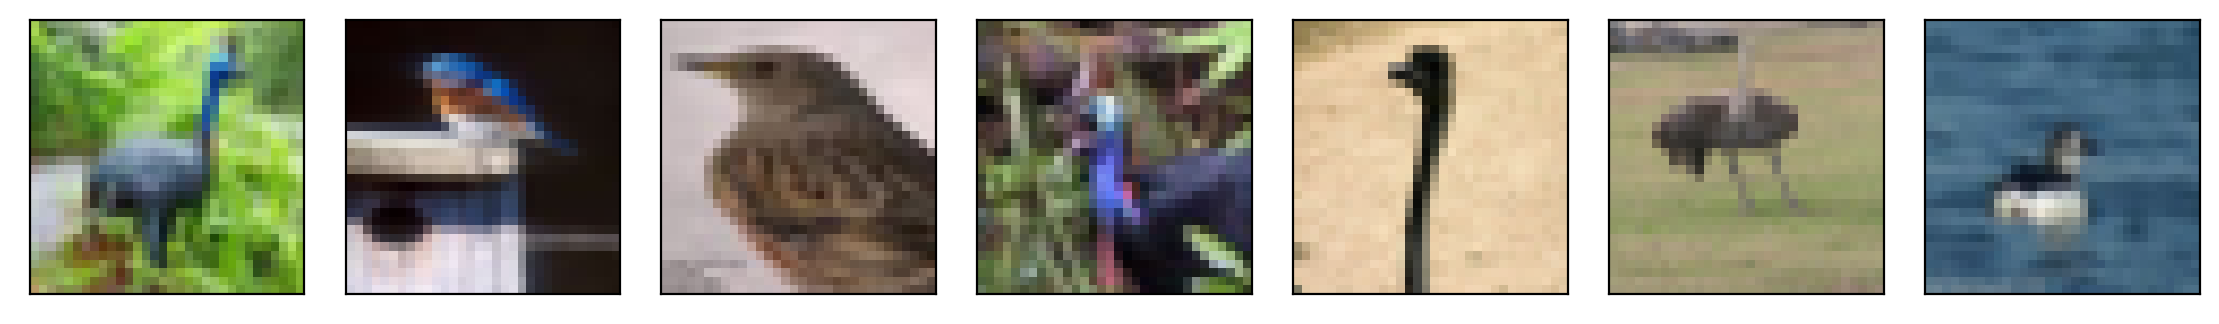

In [10]:
plot_images(train_data, range(7))

In [11]:
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)

# Модели

In [12]:
def fit(model, optim, crit, epochs, data):
    model.train()
    train_loss = []
    pbar = tqdm.trange(epochs, ascii=True)
    for i in pbar:
        avg_loss = 0
        for batch in data:
            batch = batch.to(device)
            
            optim.zero_grad()
            
            output = model(batch)
            loss = crit(batch, output)
            loss.backward()
            
            optim.step()
            avg_loss += loss.item() / len(data)
        train_loss.append(avg_loss)
        pbar.set_description(f'Epoch: {i+1}. Loss: {avg_loss:.8f}')
    
    with torch.no_grad():
        torch.cuda.empty_cache()
    return train_loss

In [8]:
class ConvLinearAutoencoder(nn.Module):
    def __init__(self, latent_space):
        super(ConvLinearAutoencoder, self).__init__()
        self.latent_space = latent_space
        self.Encoder = nn.Sequential(
            nn.Unflatten(1, (3, 32, 32)),
            nn.Conv2d(3, 8, kernel_size=3),
            nn.MaxPool2d(2, 2),
            nn.ReLU(),
            nn.Conv2d(8, 16, kernel_size=3),
            nn.MaxPool2d(2, 2),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3),
            nn.MaxPool2d(2, 2),
            nn.ReLU()
        )
        self.CNN, self.CNN_flatten = self._get_conv_output((3072,), self.Encoder)
        self.Encoder.append(nn.Sequential(
            nn.Flatten(),
            nn.Linear(self.CNN_flatten, latent_space),
            nn.Tanh()
        ))
        
        self.Decoder = nn.Sequential(
            nn.Linear(latent_space, 1024),
            nn.ReLU(),
            nn.Linear(1024, 2048),
            nn.ReLU(),
            nn.Linear(2048, 3072),
            nn.Tanh()
        )
        
    def _get_conv_output(self, shape, layers):
        bs = 1
        dummy_x = torch.empty(bs, *shape)
        x = layers(dummy_x)
        CNN = x.size()
        CNN_flatten = x.flatten(1).size(1)
        return CNN, CNN_flatten
    
    def forward(self, x):
        return self.Decoder(self.Encoder(x))

In [9]:
class ConvLinearAutoencoder_v2(nn.Module):
    def __init__(self, latent_space):
        super(ConvLinearAutoencoder_v2, self).__init__()
        self.latent_space = latent_space
        self.Encoder = nn.Sequential(
            nn.Unflatten(1, (3, 32, 32)),
            nn.Conv2d(3, 8, kernel_size=3, padding=1),
            nn.MaxPool2d(2, 2),
            nn.ReLU(),
            nn.Conv2d(8, 16, kernel_size=3, padding=1),
            nn.MaxPool2d(2, 2),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.MaxPool2d(2, 2),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.MaxPool2d(2, 2),
            nn.ReLU()
        )
        self.CNN, self.CNN_flatten = self._get_conv_output((3072,), self.Encoder)
        self.Encoder.append(nn.Sequential(
            nn.Flatten(),
            nn.Linear(self.CNN_flatten, latent_space),
            nn.Tanh()
        ))
        
        self.Decoder = nn.Sequential(
            nn.Linear(latent_space, 1024),
            nn.ReLU(),
            nn.Linear(1024, 2048),
            nn.ReLU(),
            nn.Linear(2048, 3072),
            nn.Tanh()
        )
        
    def _get_conv_output(self, shape, layers):
        bs = 1
        dummy_x = torch.empty(bs, *shape)
        x = layers(dummy_x)
        CNN = x.size()
        CNN_flatten = x.flatten(1).size(1)
        return CNN, CNN_flatten
    
    def forward(self, x):
        return self.Decoder(self.Encoder(x))

In [10]:
class ConvAutoencoder(nn.Module):
    def __init__(self, latent_space):
        super(ConvAutoencoder, self).__init__()
        self.latent_space = latent_space

        self.Encoder = nn.Sequential(
            nn.Unflatten(1, (3, 32, 32)),
            nn.Conv2d(3, 8, kernel_size=3, padding=1),
            nn.MaxPool2d(2, 2),
            nn.ReLU(),
            nn.Conv2d(8, 16, kernel_size=3, padding=1),
            nn.MaxPool2d(2, 2),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.MaxPool2d(2, 2),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.MaxPool2d(2, 2),
            nn.ReLU()
        )
        self.CNN, self.CNN_flatten = self._get_conv_output((3072,), self.Encoder)
        self.Encoder.append(nn.Sequential(
            nn.Flatten(),
            nn.Linear(self.CNN_flatten, latent_space),
            nn.Tanh()
        ))
        
        self.Decoder = nn.Sequential(
            nn.Linear(latent_space, self.CNN_flatten),
            nn.ReLU(),
            nn.Unflatten(1, self.CNN[1:]),
            nn.Upsample(scale_factor=2),
            nn.ConvTranspose2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),
            nn.ConvTranspose2d(32, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),
            nn.ConvTranspose2d(16, 8, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),
            nn.ConvTranspose2d(8, 3, kernel_size=3, padding=1),
            nn.Flatten(),
            nn.Tanh()
        )
        
    def _get_conv_output(self, shape, layers):
        bs = 1
        dummy_x = torch.empty(bs, *shape)
        x = layers(dummy_x)
        CNN = x.size()
        CNN_flatten = x.flatten(1).size(1)
        return CNN, CNN_flatten
    
    def forward(self, x):
        return self.Decoder(self.Encoder(x))

# Обучение моделей

## Линейная с тремя слоями

In [ ]:
encoder = nn.Sequential(
    nn.Linear(3072, 1024),
    nn.Tanh(),
    nn.Linear(1024, 96),
    nn.Tanh()
)

decoder = nn.Sequential(
    nn.Linear(96, 1024),
    nn.Tanh(),
    nn.Linear(1024, 3072),
    nn.Tanh()
)

model = nn.Sequential(encoder, decoder).to(device)

In [ ]:
hist = fit(model, torch.optim.Adam(model.parameters()), nn.MSELoss(), 1000, train_loader)

In [ ]:
torch.save(model, 'linear_3072_1024_96_tanh.pkl')
save(hist, 'linear_3072_1024_96_tanh_history.pkl')

## Линейная с четырьмя слоями

In [ ]:
encoder = nn.Sequential(
    nn.Linear(3072, 2048),
    nn.ReLU(),
    nn.Linear(2048, 1024),
    nn.ReLU(),
    nn.Linear(1024, 128),
    nn.Tanh()
)

decoder = nn.Sequential(
    nn.Linear(128, 1024),
    nn.ReLU(),
    nn.Linear(1024, 2048),
    nn.ReLU(),
    nn.Linear(2048, 3072),
    nn.Tanh()
)

model = nn.Sequential(encoder, decoder).to(device)

In [ ]:
hist = fit(model, torch.optim.Adam(model.parameters()), nn.MSELoss(), 1000, train_loader)

In [ ]:
torch.save(model, 'linear_3072_2048_1024_128_relu.pkl')
save(hist, 'linear_3072_2048_1024_128_relu_history.pkl')

## Сверточно-линейная

In [19]:
model = ConvLinearAutoencoder(128).to(device)

In [20]:
hist = fit(model, torch.optim.Adam(model.parameters(), lr=1e-4), nn.MSELoss(), 1000, train_loader)

Epoch: 1000. Loss: 0.00029149: 100%|##########| 1000/1000 [04:02<00:00,  4.12it/s]


In [23]:
torch.save(model, 'conv_linear.pkl')
save(hist, 'conv_linear_history.pkl')

## Сверточно-линейная (версия 2)

In [24]:
model = ConvLinearAutoencoder_v2(128).to(device)

In [25]:
hist = fit(model, torch.optim.Adam(model.parameters(), lr=1e-4), nn.MSELoss(), 1000, train_loader)

Epoch: 1000. Loss: 0.00034468: 100%|##########| 1000/1000 [04:08<00:00,  4.03it/s]


In [28]:
torch.save(model, 'conv_linear_v2.pkl')
save(hist, 'conv_linear_v2_history.pkl')

## Сверточная

In [43]:
model = ConvAutoencoder(128).to(device)

In [44]:
hist = fit(model, torch.optim.Adam(model.parameters(), lr=1e-5), nn.MSELoss(), 3000, train_loader)

Epoch: 3000. Loss: 0.04224069: 100%|##########| 3000/3000 [09:45<00:00,  5.12it/s]


In [47]:
torch.save(model, 'conv.pkl')
save(hist, 'conv_history.pkl')

# Тестирование моделей

In [11]:
def modifications(decoder, encoder, data_images, latent_space, count, images_count=1):
    images = []
    titles = ['Input', 'Output', 'Modifications']
    for _ in range(images_count):
        image = data_images[np.random.randint(len(data_images))]
        features = encoder(torch.from_numpy(image).to(device).unsqueeze(0)).detach().cpu()[0].numpy()
        images += [image, decoder(torch.from_numpy(features).to(device).unsqueeze(0)).detach().cpu()[0].numpy()]
        for _ in range(5):
            idx = np.random.randint(latent_space, size=count)
            mod = np.copy(features)
            mod[idx] = np.random.rand(count) * 2 - 1
            images.append(decoder(torch.from_numpy(mod).to(device).unsqueeze(0)).detach().cpu()[0].numpy())
    plot_images(images, titles=titles, w=7)

## Линейная с тремя слоями

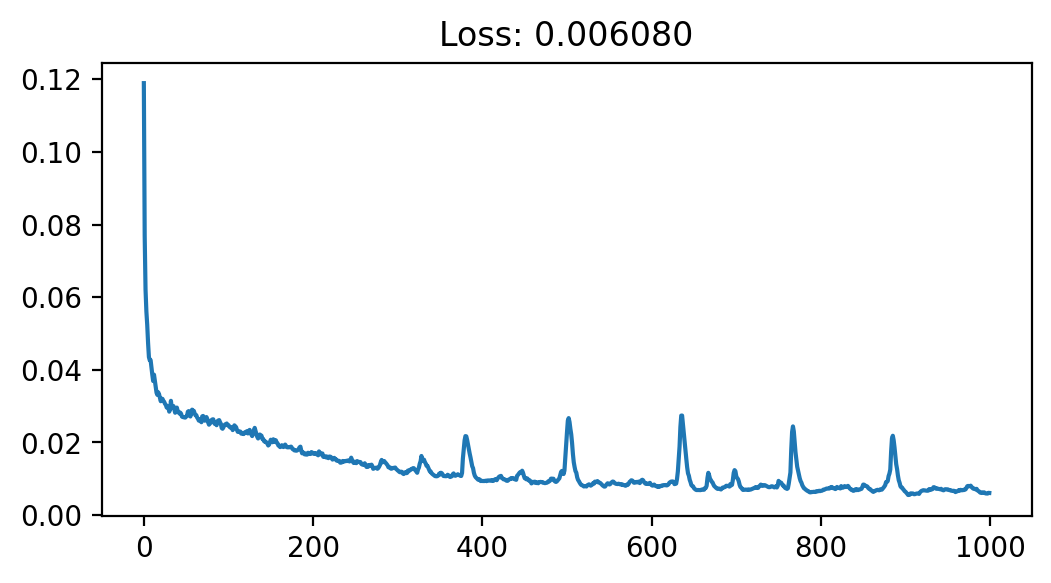

In [12]:
model = torch.load('linear_3072_1024_96_tanh.pkl', map_location=device)
model.eval()
encoder = model[0]
decoder = model[1]
latent_space = 96

plot_history(load('linear_3072_1024_96_tanh_history.pkl'))

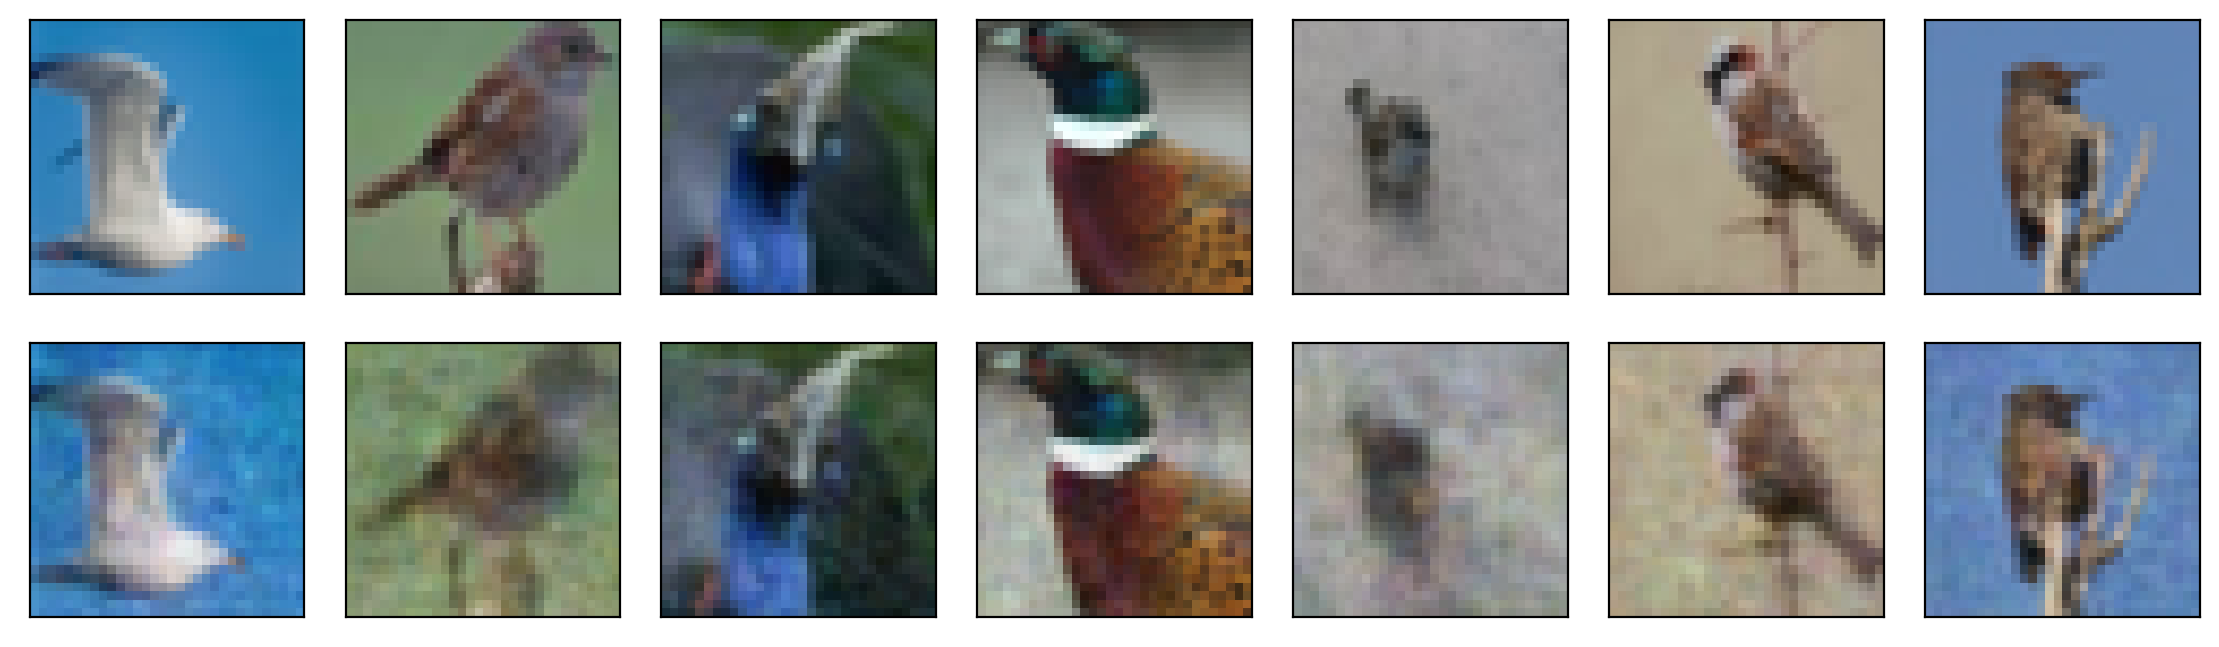

In [19]:
plot_results(model, train_data)

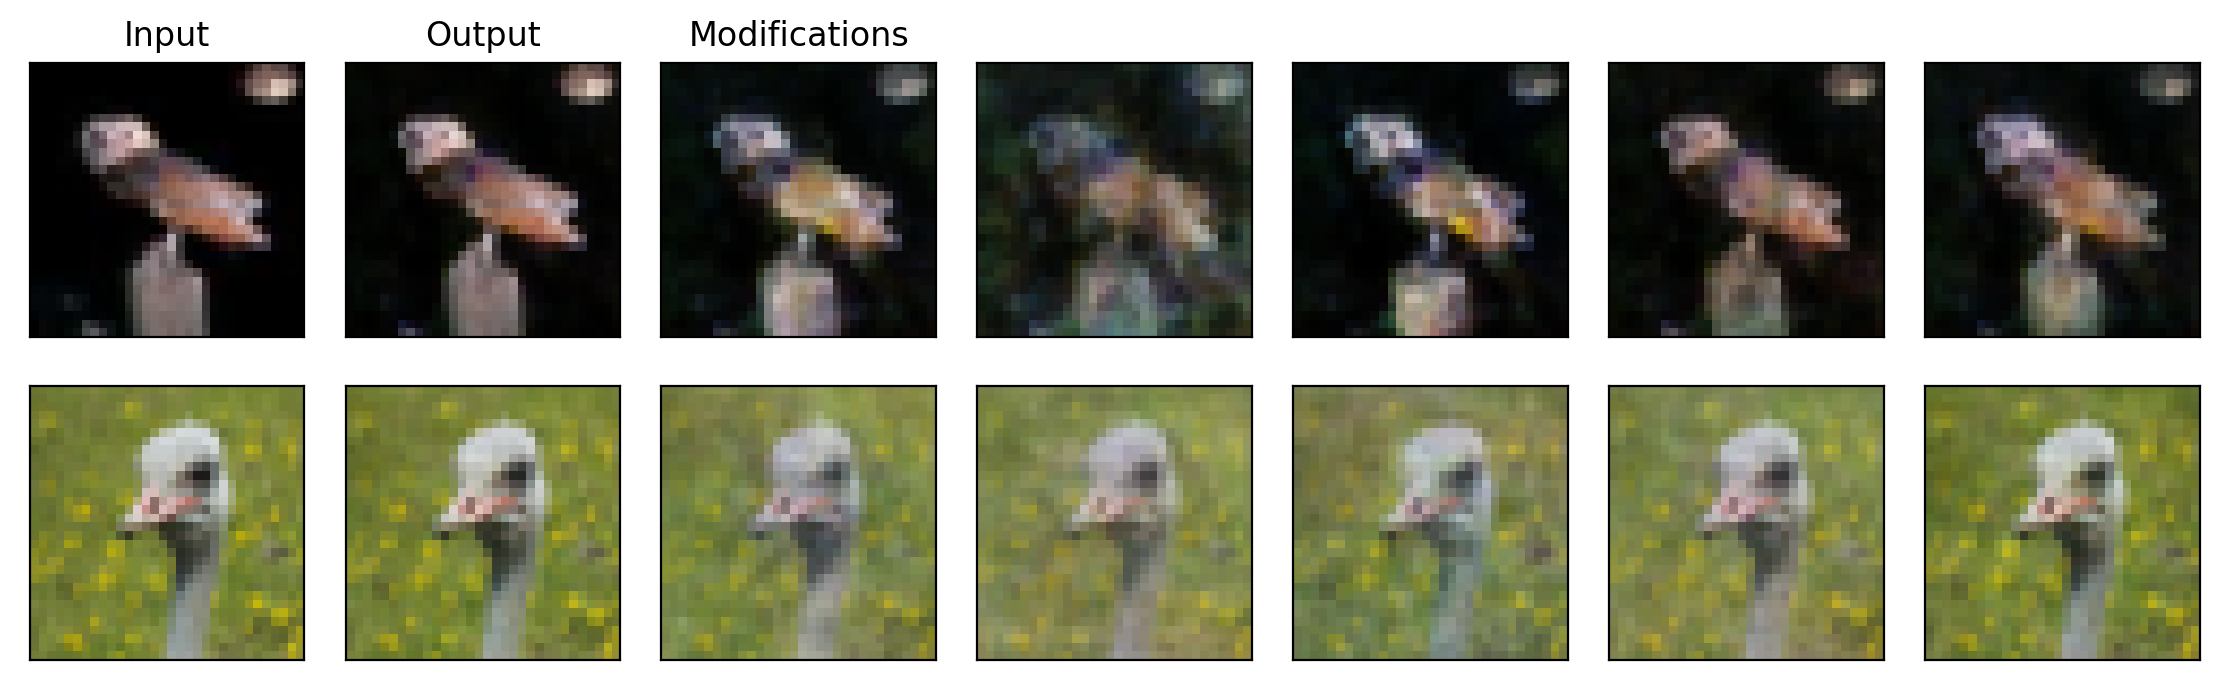

In [ ]:
modifications(decoder, encoder, train_data, latent_space, 12, 2)

## Линейная с четырьмя слоями

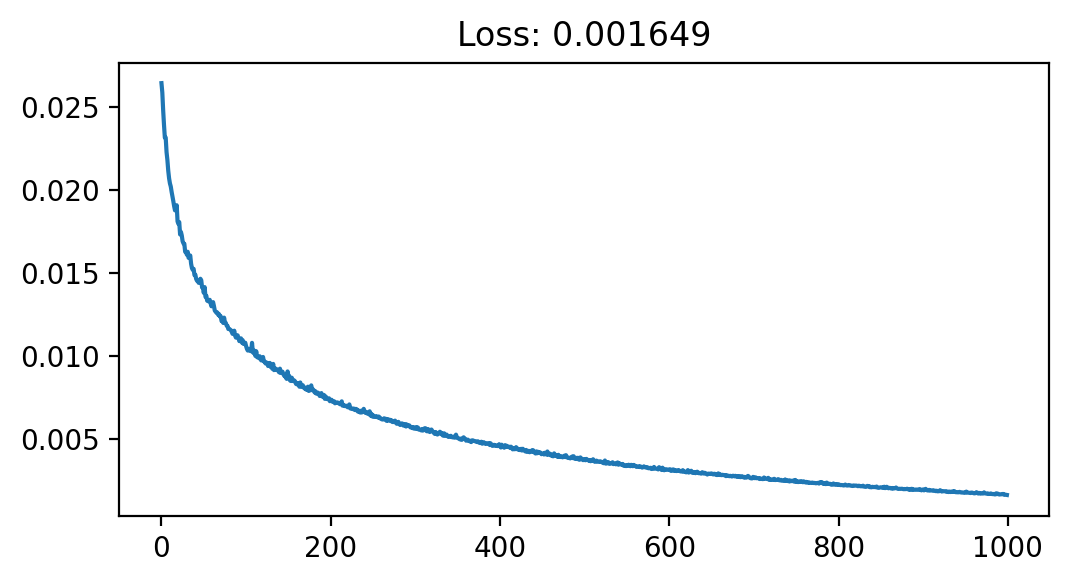

In [52]:
model = torch.load('linear_3072_2048_1024_128_relu.pkl', map_location=device)
model.eval()
encoder = model[0]
decoder = model[1]
latent_space = 128

plot_history(load('linear_3072_2048_1024_128_relu_history.pkl'))

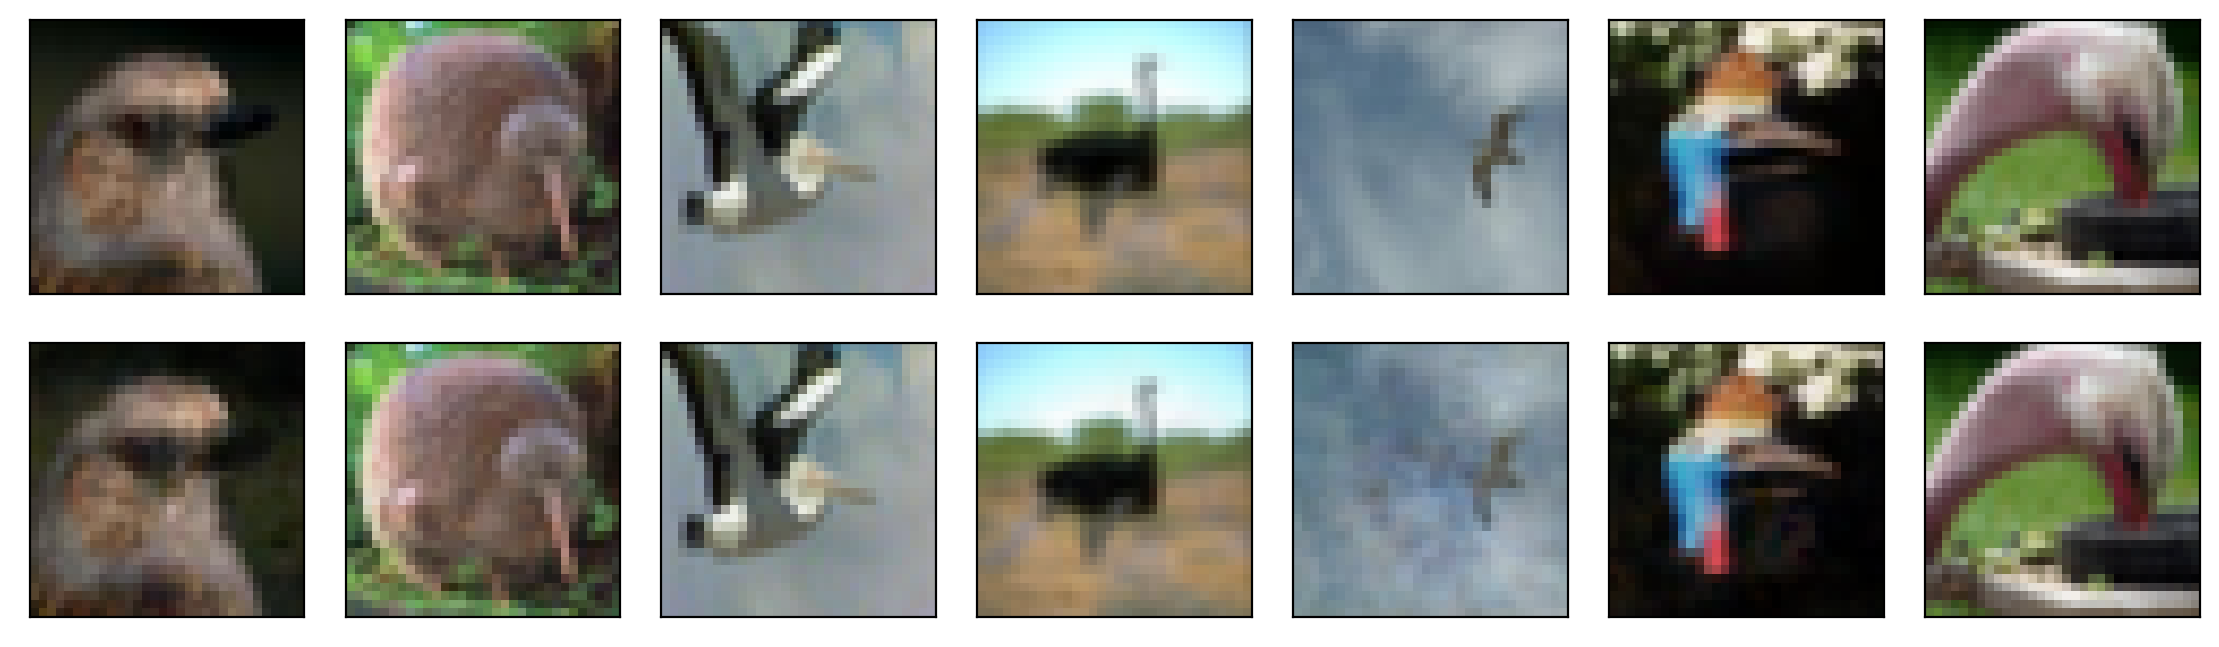

In [ ]:
plot_results(model, train_data)

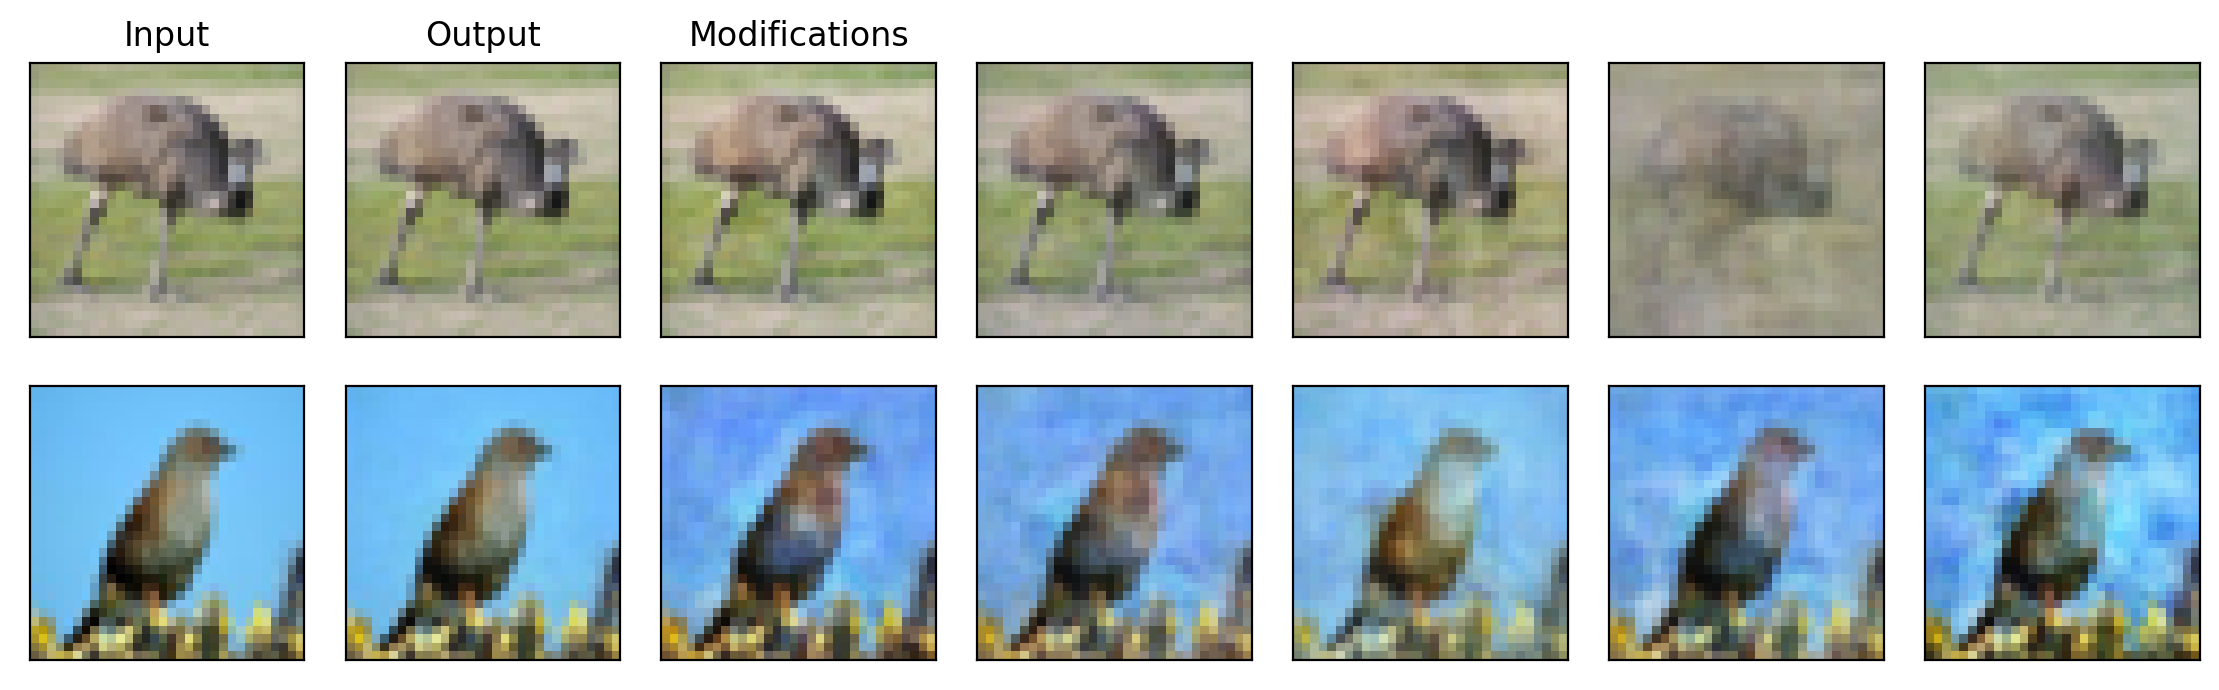

In [ ]:
modifications(decoder, encoder, train_data, latent_space, 10, 2)

## Сверточно-линейная

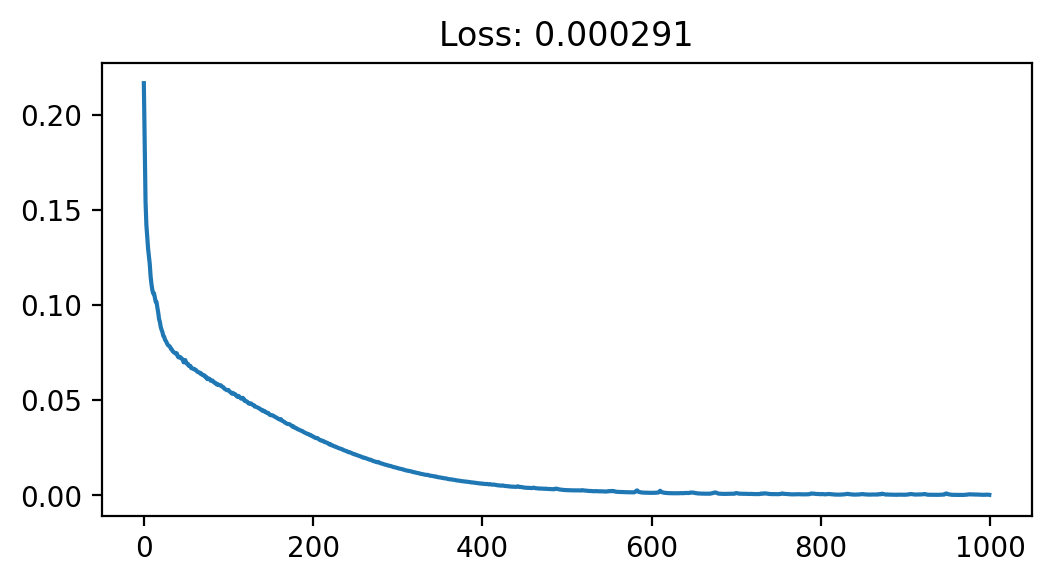

In [16]:
model = torch.load('conv_linear.pkl', map_location=device)
model.eval()
encoder = model.Encoder
decoder = model.Decoder
latent_space = model.latent_space

plot_history(load('conv_linear_history.pkl'))

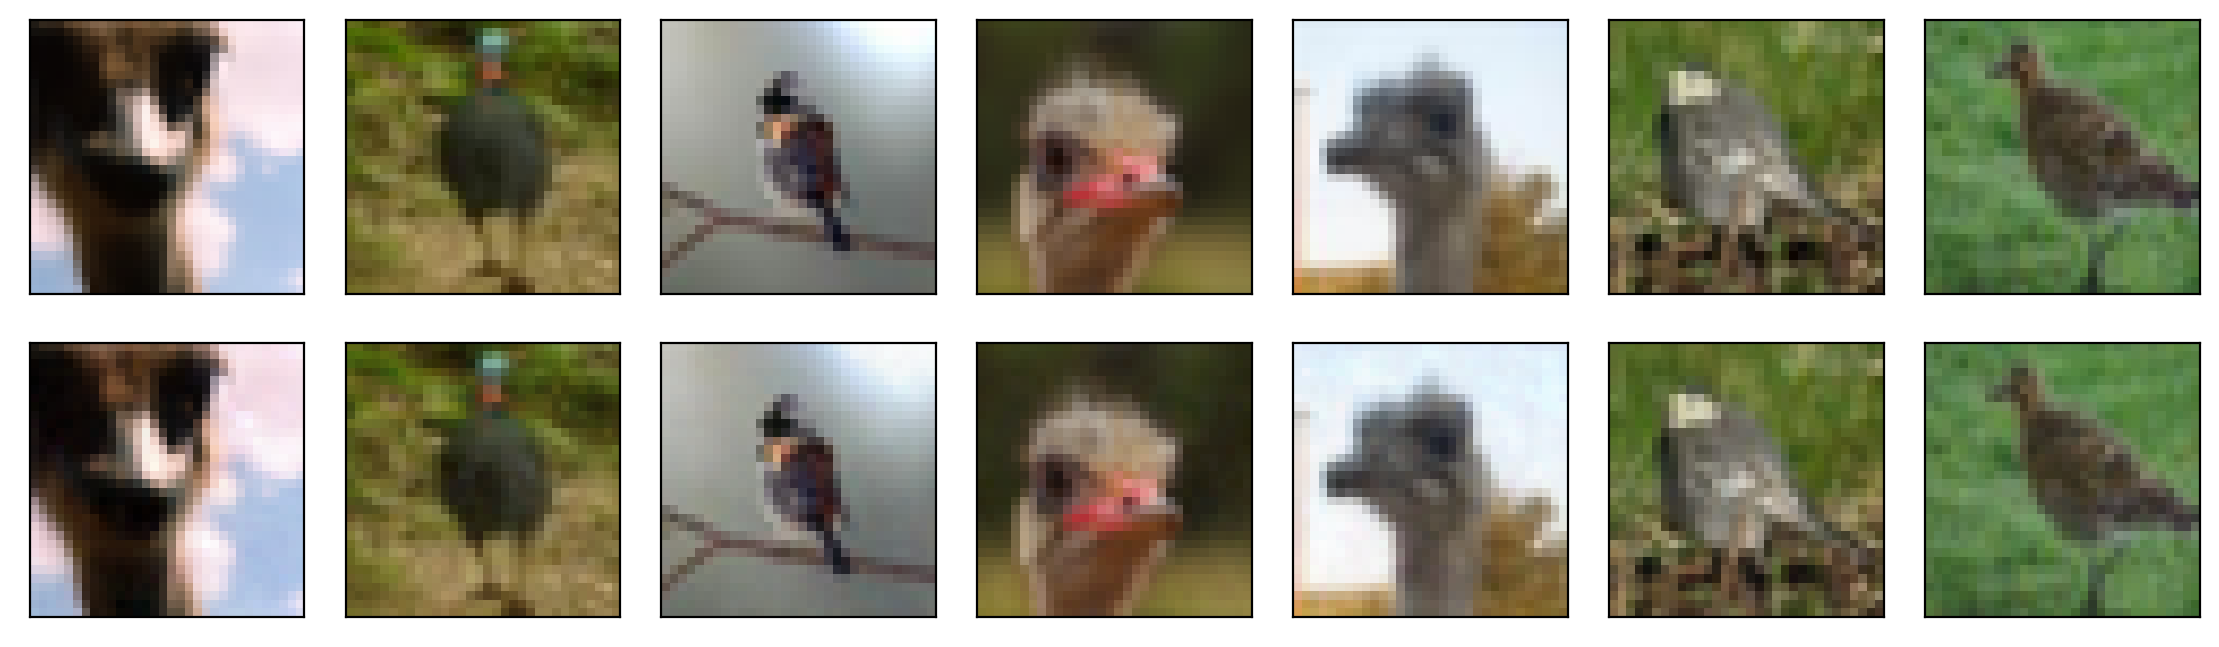

In [ ]:
plot_results(model, train_data)

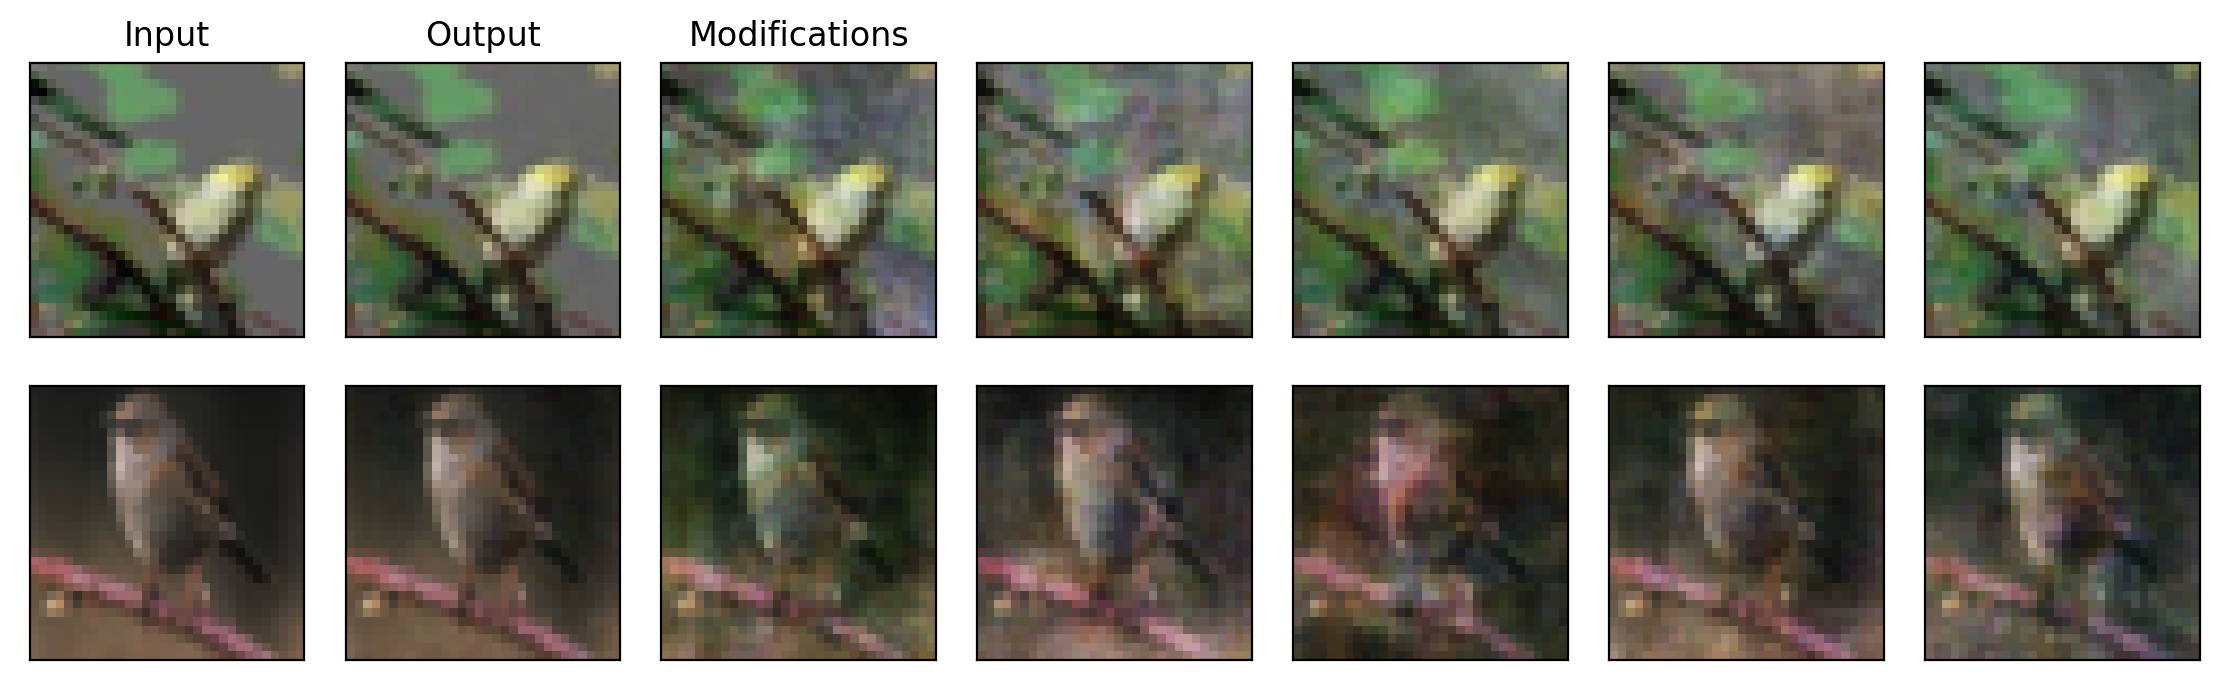

In [20]:
modifications(decoder, encoder, train_data, latent_space, 4, 2)

## Сверточно-линейная (версия 2)

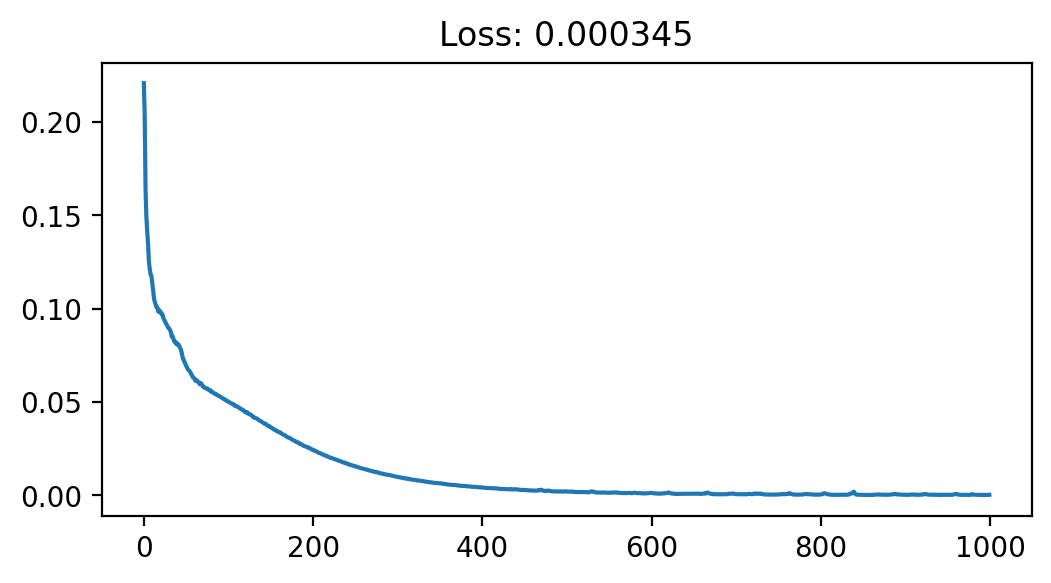

In [50]:
model = torch.load('conv_linear_v2.pkl', map_location=device)
model.eval()
encoder = model.Encoder
decoder = model.Decoder
latent_space = model.latent_space

plot_history(load('conv_linear_v2_history.pkl'))

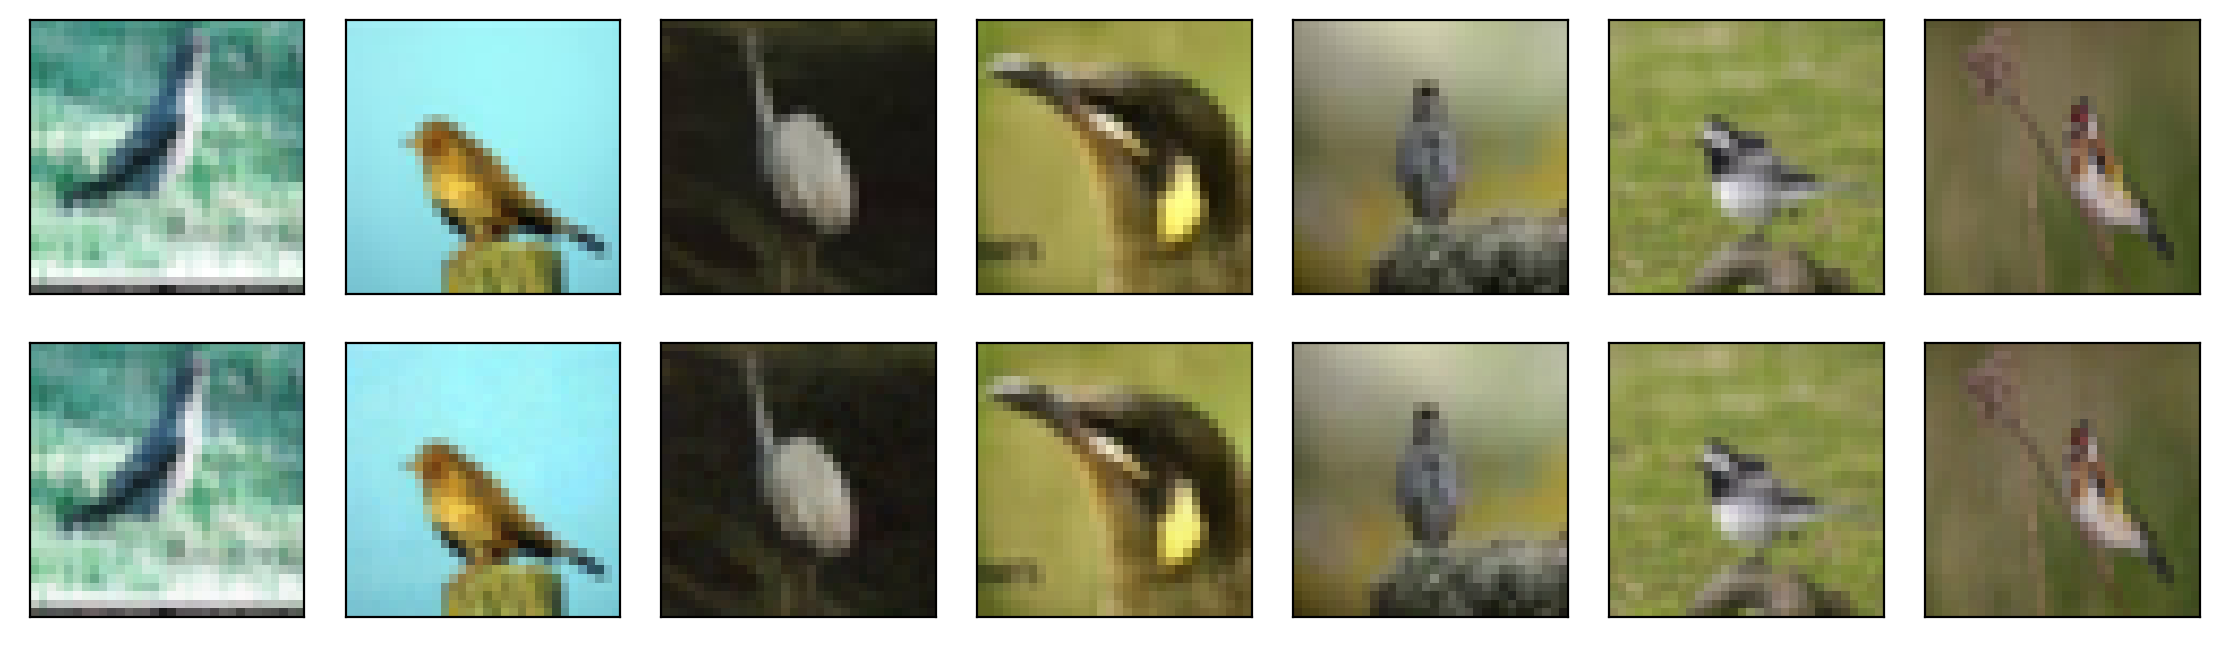

In [51]:
plot_results(model, train_data)

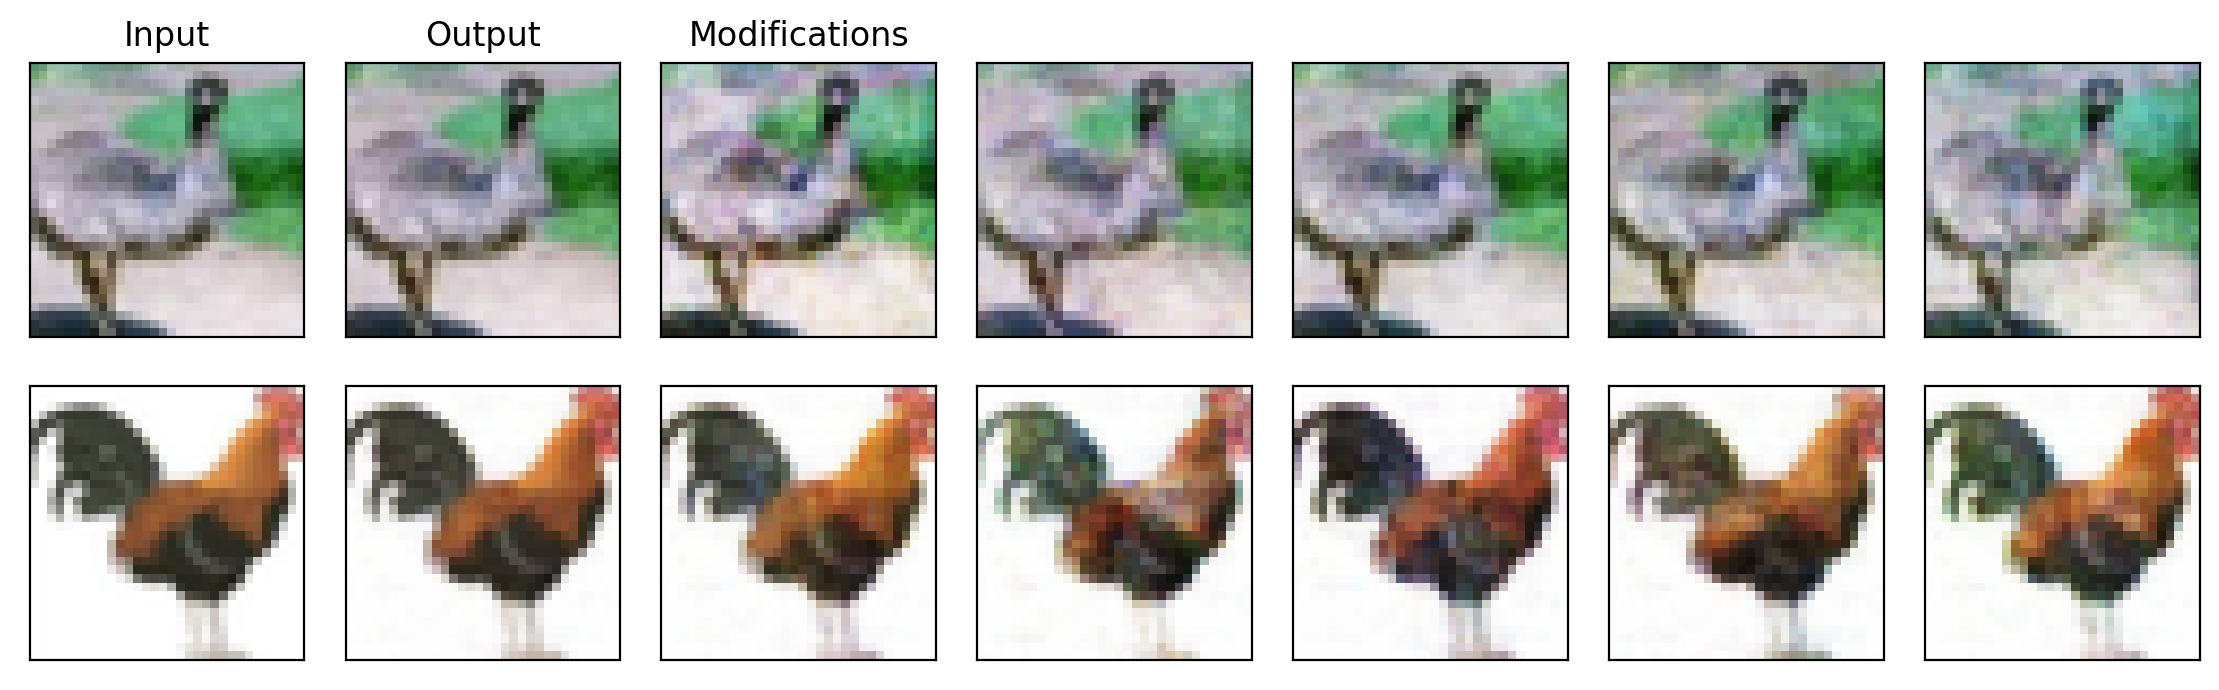

In [44]:
modifications(decoder, encoder, train_data, latent_space, 7, 2)

## Сверточная

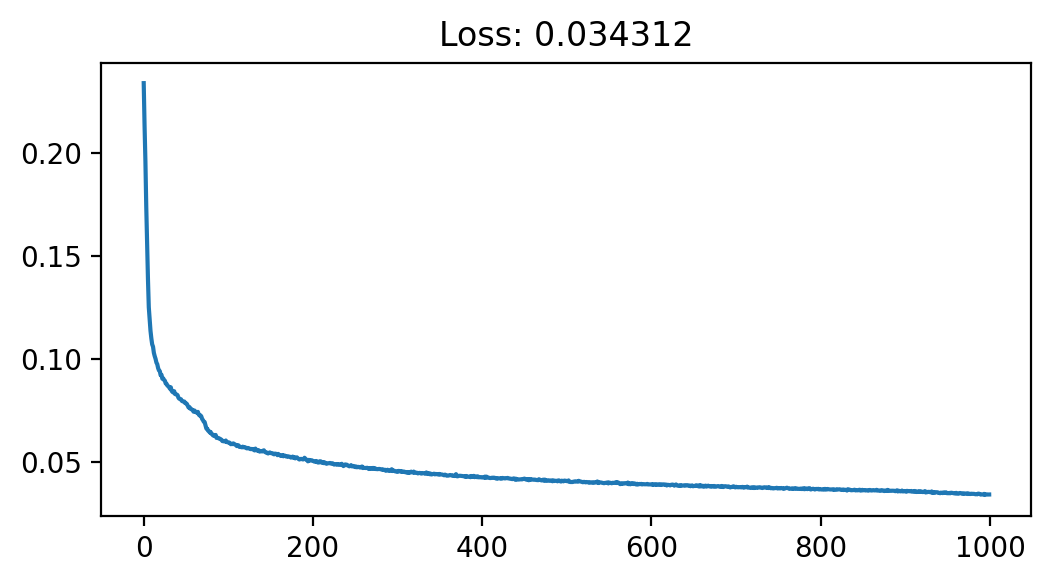

In [40]:
model = torch.load('conv.pkl', map_location=device)
model.eval()
encoder = model.Encoder
decoder = model.Decoder
latent_space = model.latent_space

plot_history(load('conv_history.pkl'))

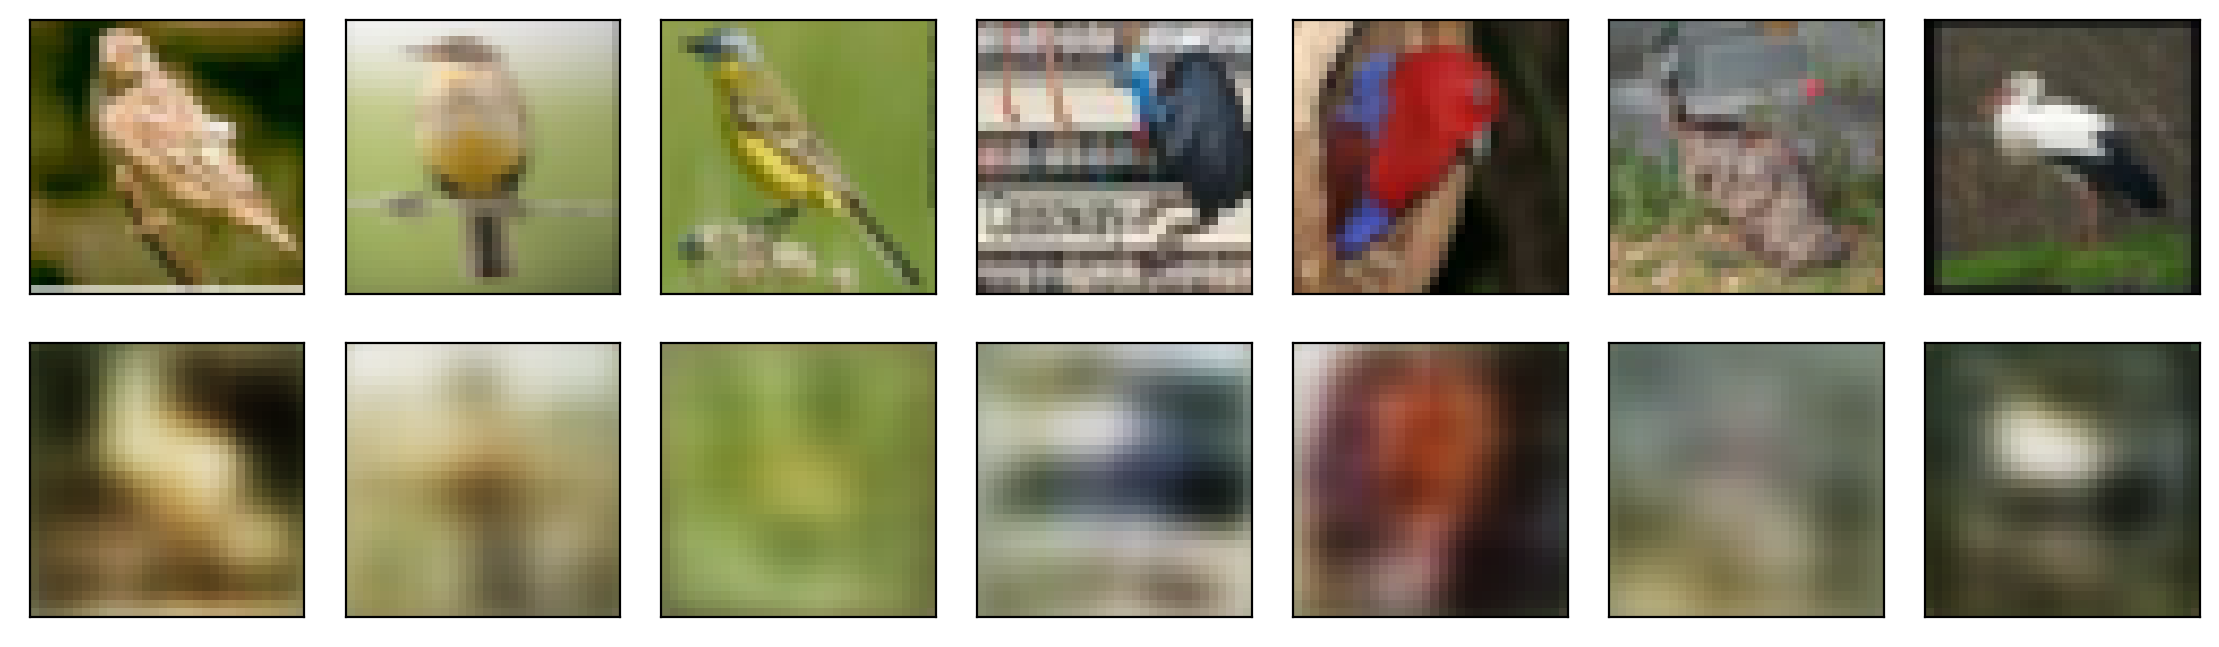

In [41]:
plot_results(model, train_data)

## Интерполяция между изображениями

In [47]:
def animate_images_interpolation(encoder, decoder, image1, image2, samples=50, interval=75, video=False):
    def animate(t, decoder, features1, features2):
        features = features1 * (1 - t) + features2 * t
        img.set_data(decoder(features).detach().cpu()[0].numpy().reshape(3, 32, 32).transpose([1, 2, 0]) / 2 + 0.5)
        return (img,)

    fig = plt.figure()
    ax = fig.gca()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    t = np.concatenate((np.linspace(0, 1, samples), np.linspace(1, 0, samples)))
    features1 = encoder(torch.from_numpy(image1).to(device).unsqueeze(0)).detach()
    features2 = encoder(torch.from_numpy(image2).to(device).unsqueeze(0)).detach()
    
    img = ax.imshow(decoder(features1).detach().cpu()[0].numpy().reshape(3, 32, 32).transpose([1, 2, 0]) / 2 + 0.5, interpolation='bicubic')
    anim = animation.FuncAnimation(fig, animate, fargs = (decoder, features1, features2),
                                   frames=t, interval=interval, blit=True)
    plt.close()
    if video:
        return HTML(anim.to_html5_video())
    else:
        return HTML(anim.to_jshtml())

def plot_images_interpolation(encoder, decoder, image1, image2, samples):
    tt = np.linspace(0, 1, samples)
    features1 = encoder(torch.from_numpy(image1).to(device).unsqueeze(0)).detach()
    features2 = encoder(torch.from_numpy(image2).to(device).unsqueeze(0)).detach()
    
    images = []
    for t in tt:
        features = features1 * (1 - t) + features2 * t
        images.append(decoder(features).detach().cpu()[0].numpy())
    
    plot_images(images, interp='bicubic')

In [37]:
model = torch.load('linear_3072_1024_96_tanh.pkl', map_location=device)
model.eval()
encoder = model[0]
decoder = model[1]
animate_images_interpolation(encoder, decoder, train_data[0], train_data[1], samples=100, video=True)

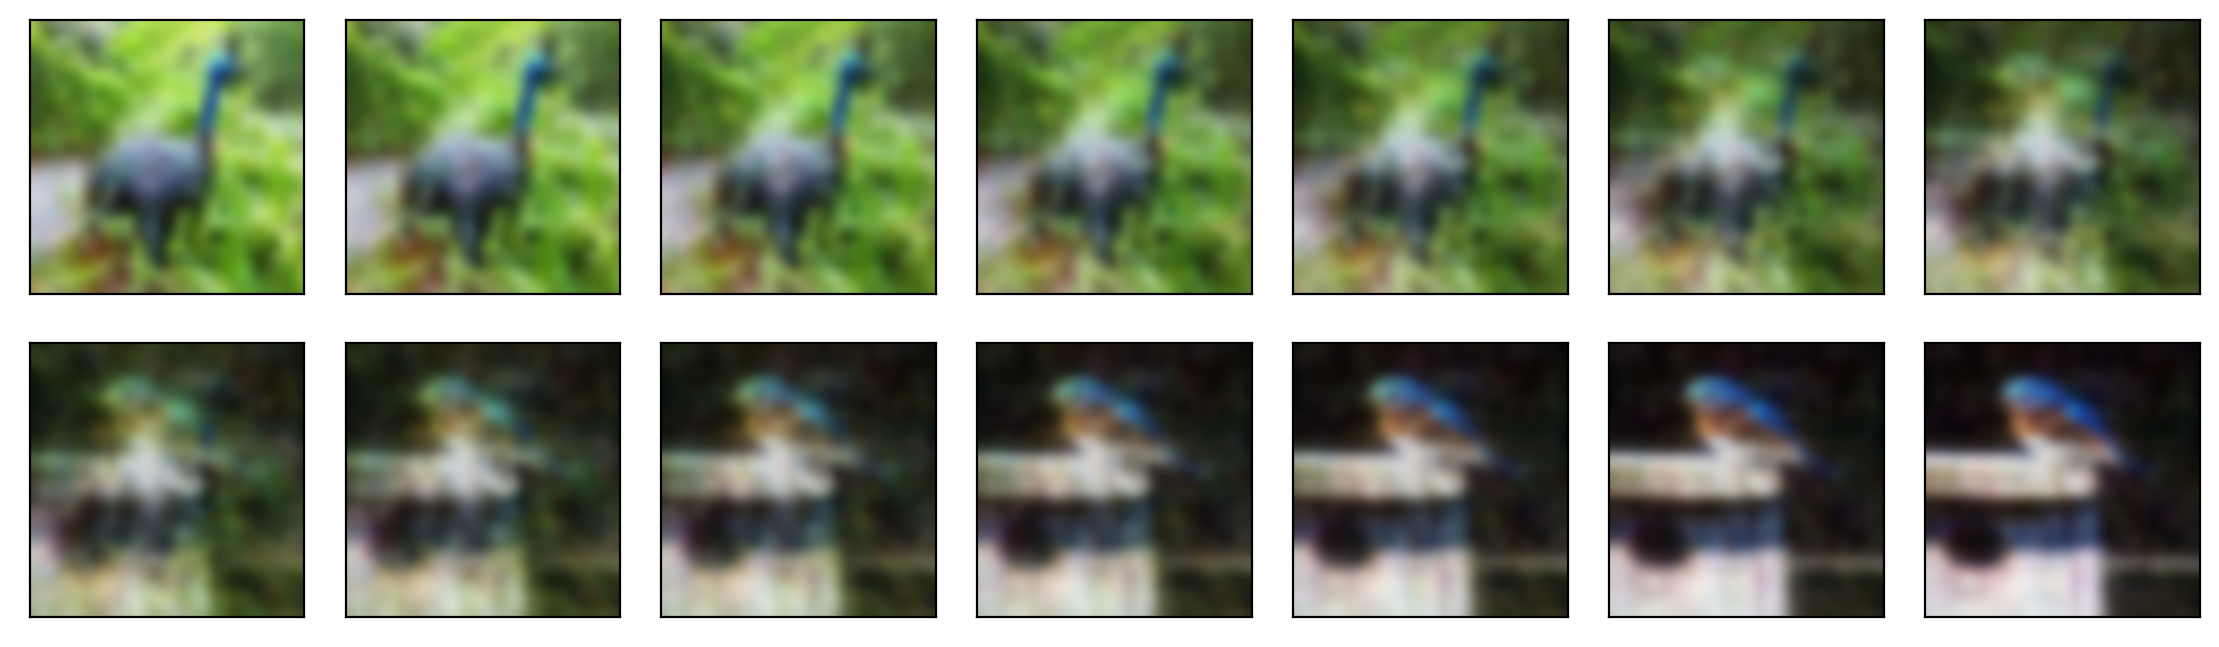

In [38]:
plot_images_interpolation(encoder, decoder, train_data[0], train_data[1], 14)

In [39]:
model = torch.load('linear_3072_2048_1024_128_relu.pkl', map_location=device)
model.eval()
encoder = model[0]
decoder = model[1]
animate_images_interpolation(encoder, decoder, train_data[0], train_data[1], samples=100, video=True)

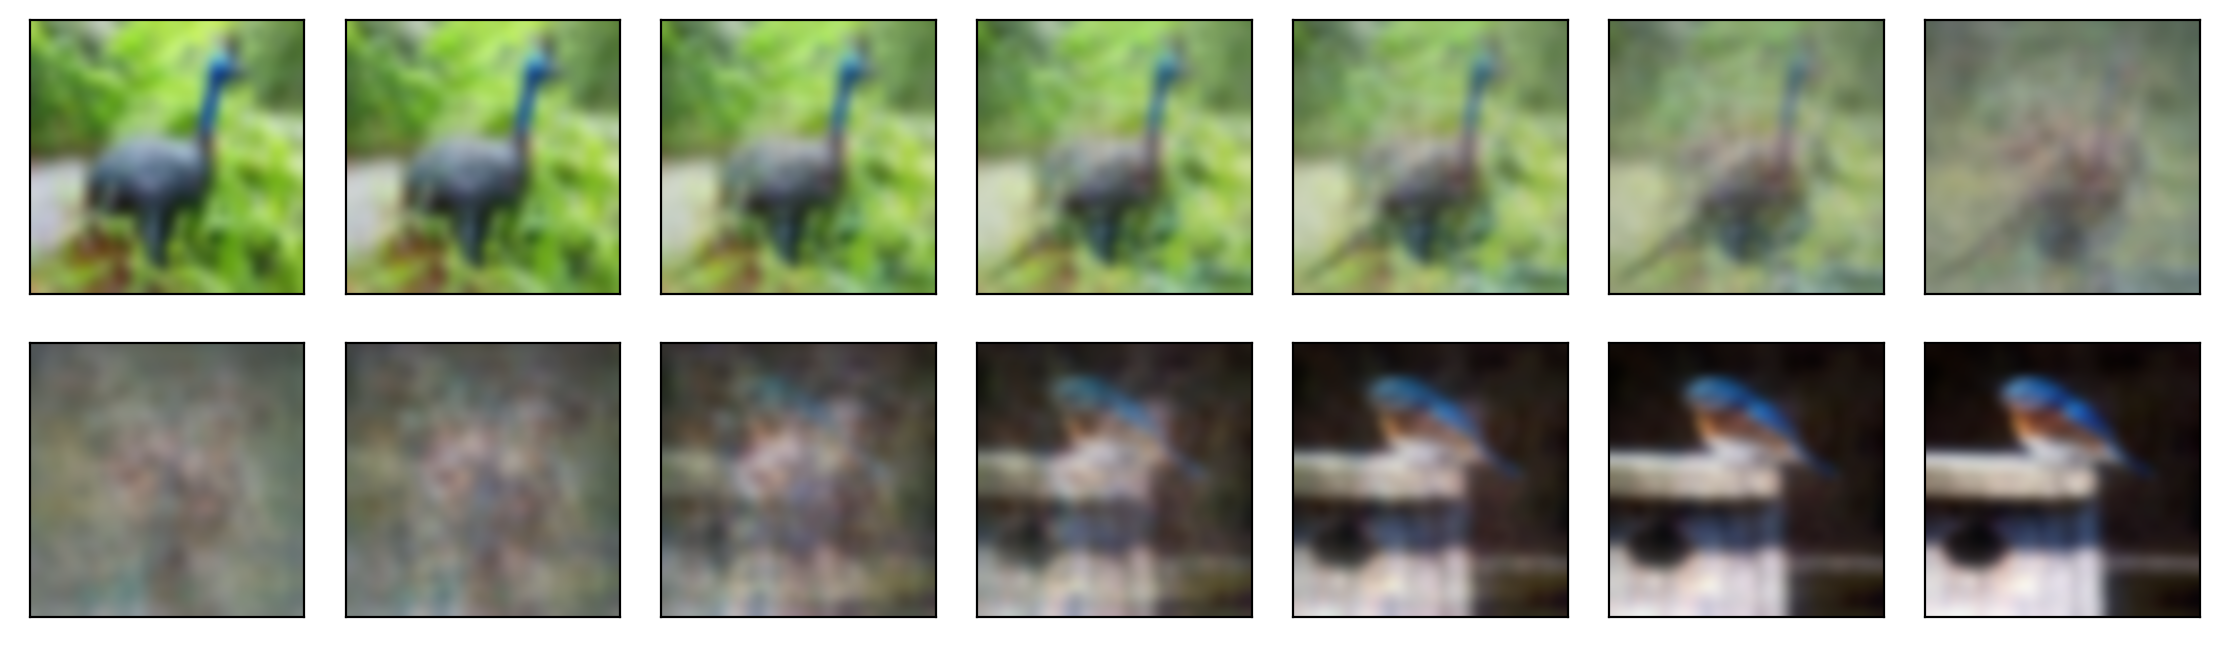

In [40]:
plot_images_interpolation(encoder, decoder, train_data[0], train_data[1], 14)

In [48]:
model = torch.load('conv_linear.pkl', map_location=device)
model.eval()
encoder = model.Encoder
decoder = model.Decoder
animate_images_interpolation(encoder, decoder, train_data[0], train_data[1], samples=100, video=True)

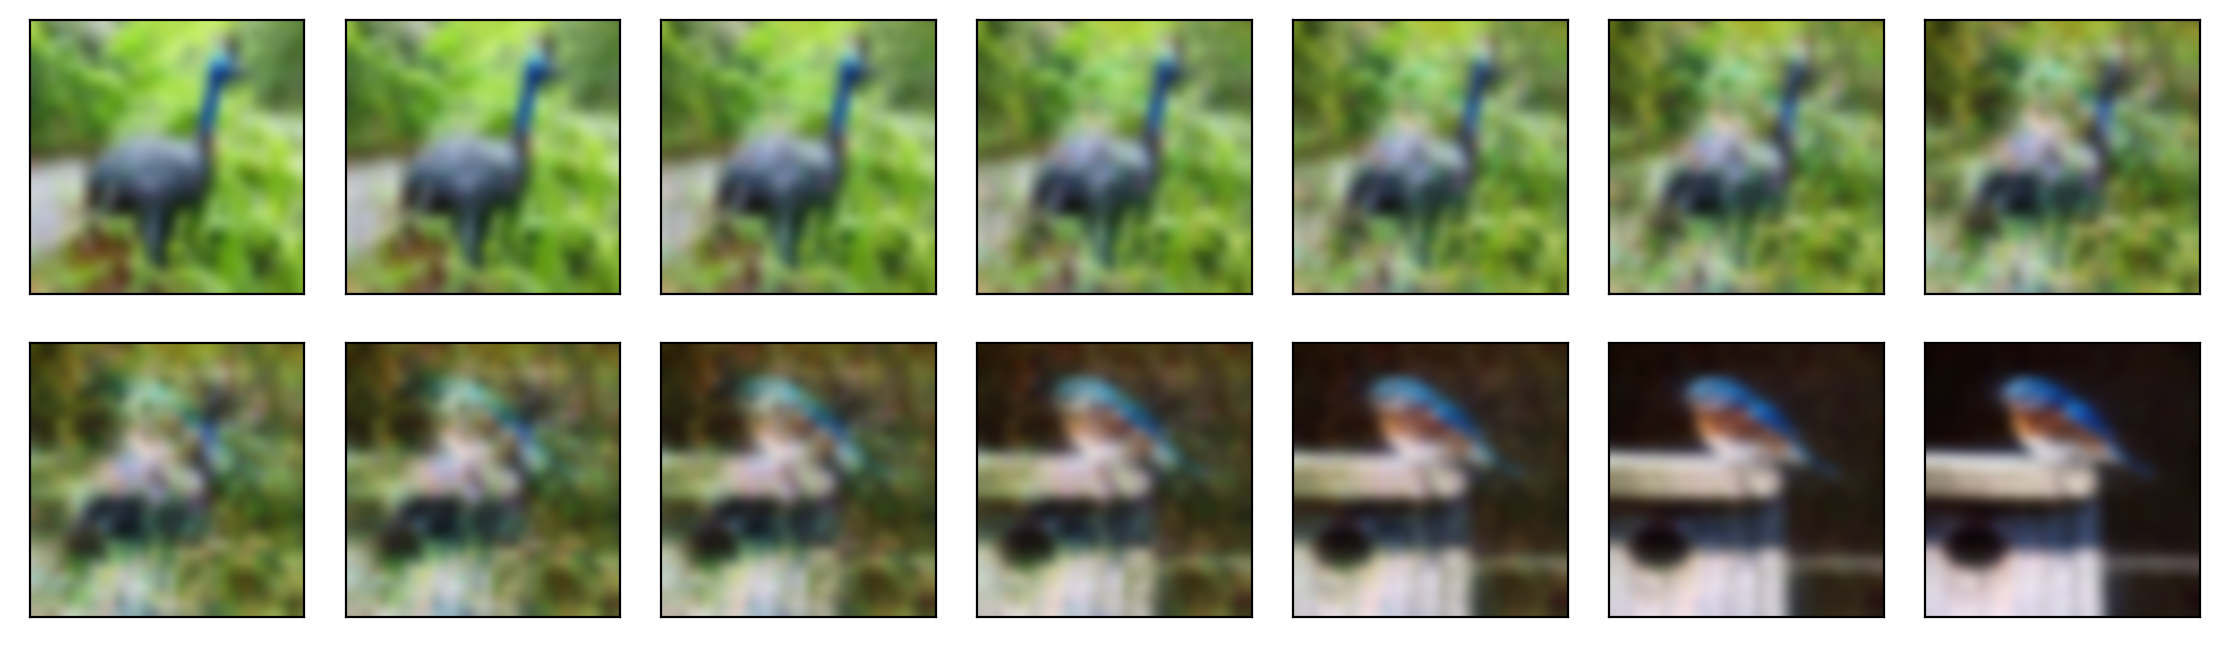

In [49]:
plot_images_interpolation(encoder, decoder, train_data[0], train_data[1], 14)